In [13]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

## 1. Load and merge data

In [7]:
# CUSTOMER id únic per cada línea de la taula (a priori no és útil), customer_unique_id client únic
customers_df = pd.read_csv('data/olist_customers_dataset.csv')
# ORDER and PRODUCT relationship, with price, seller, shipping, etc.
order_items_df = pd.read_csv('data/olist_order_items_dataset.csv')
orders_df = pd.read_csv('data/olist_orders_dataset.csv')
products_df = pd.read_csv('data/olist_products_dataset.csv')

In [8]:
orders_customers_df = pd.merge(orders_df, customers_df, on='customer_id', how='left')
# a partir d'aquí estem a nivell de PRODUCTE comprat
df = pd.merge(order_items_df, orders_customers_df, on='order_id', how='left')
df = pd.merge(df, products_df, on='product_id', how='left')

# Translate product category names to English
translation_df = pd.read_csv('data/product_category_name_translation.csv')
translation_dict = dict(zip(translation_df["product_category_name"], translation_df["product_category_name_english"]))
df["product_category_name"] = df["product_category_name"].replace(translation_dict)

## Exploratory

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date


def plot_orders_general(data, date_col):
    grouped = data.groupby([date_col]).size().reset_index(name="num_orders")
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=grouped, x='order_purchase', y='num_orders')
    plt.title("Orders per Category by Day")
    plt.show()

def plot_orders_by_category(data, date_col, category_cols):
    data = data[data["product_category_name"].isin(category_cols)]
    grouped = data.groupby(["order_purchase","product_category_name"]).size().reset_index(name="num_orders")
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=grouped, x='order_purchase', y='num_orders', hue="product_category_name")
    plt.title("Orders per Category by Day")
    plt.show()


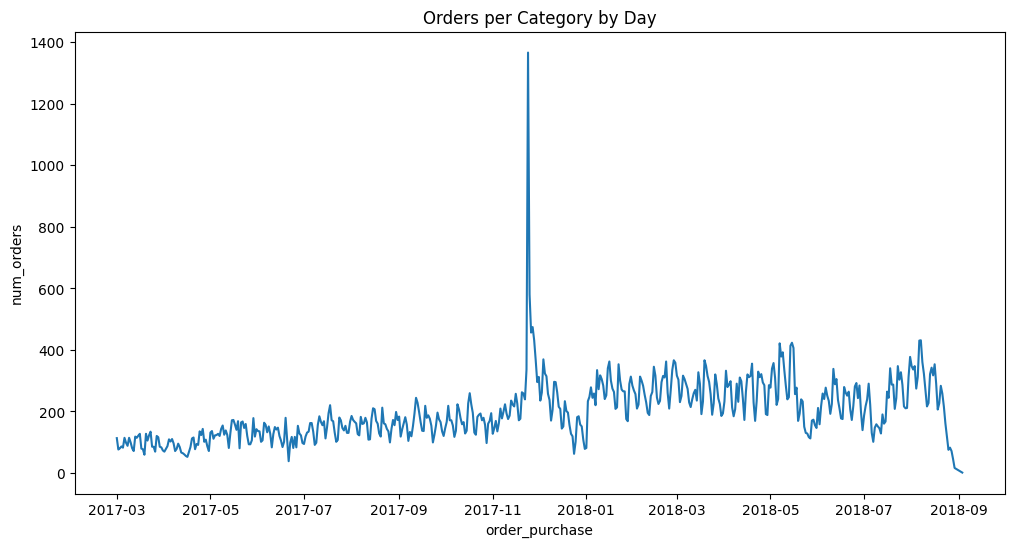

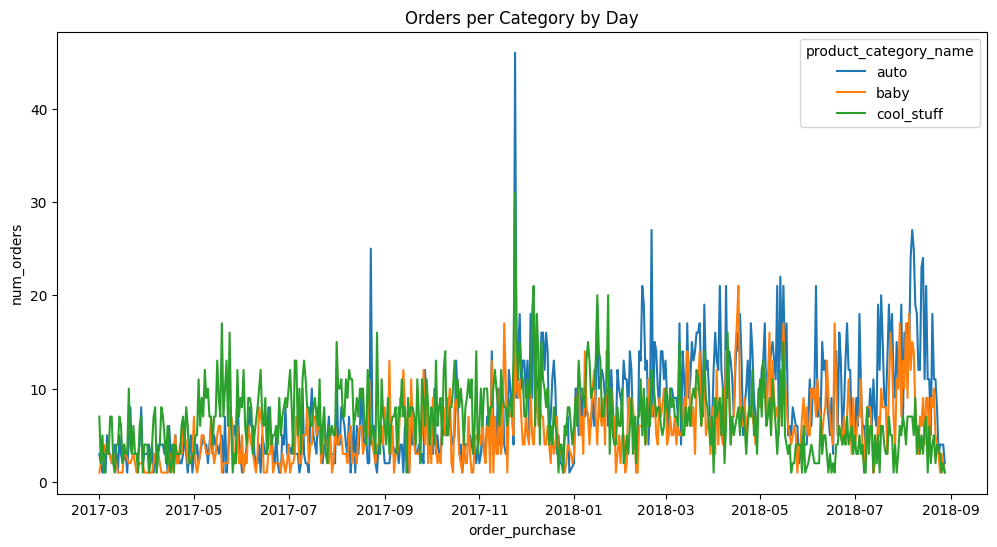

In [11]:
df = df[(df["order_purchase_timestamp"]>"2017-03-01") ].copy()
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
df["order_purchase"] = pd.to_datetime(df["order_purchase_timestamp"]).dt.date

plot_orders_general(df, "order_purchase")
plot_orders_by_category(df, "order_purchase", ["auto","baby","cool_stuff"])

## Model - Forecasting

In [15]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint

2025-05-15 18:15:20.856695: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [95]:
spd_df = df.groupby(["order_purchase"]).size().reset_index(name="num_orders")
spd_df["order_purchase"] = pd.to_datetime(spd_df["order_purchase"])
# spd_df = spd_df.set_index("order_purchase").sort_index()
spd_df = spd_df[(spd_df["order_purchase"]>"2017-01-01") & (spd_df["order_purchase"]<"2018-08-01")]

In [96]:
spd_df.loc[spd_df["order_purchase"]=="2017-11-24", "num_orders"] = 431
spd_df.loc[spd_df["order_purchase"]=="2017-11-24", "num_orders"] = 411
spd_df.loc[spd_df["order_purchase"]=="2017-11-25", "num_orders"] = 475

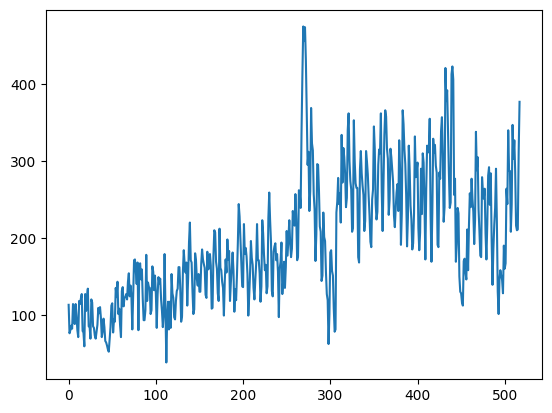

In [97]:
plt.plot(spd_df["num_orders"])

In [98]:
def df_to_X_y(data, window_size):
    data_numpy = data.to_numpy()
    X, y = [], []
    for i in range(len(data_numpy)-window_size):
        X.append(data_numpy[i:i+window_size])
        y.append(data_numpy[i+window_size])
    return np.array(X), np.array(y)

WINDOW_SIZE = 40
scaler = MinMaxScaler()
X, y = df_to_X_y(spd_df["num_orders"], WINDOW_SIZE)
X = scaler.fit_transform(X)
X = X.reshape((X.shape[0], X.shape[1], 1))
y = scaler.fit_transform(y.reshape(-1, 1))
X.shape, y.shape

((478, 40, 1), (478, 1))

In [99]:
X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]
X_val, y_val = X[int(len(X)*0.8):int(len(X)*0.9)], y[int(len(y)*0.8):int(len(X)*0.9)]
X_test, y_test = X[int(len(X)*0.9):], y[int(len(y)*0.9):]


In [100]:
model = Sequential()
model.add(InputLayer((WINDOW_SIZE, 1)))
model.add(LSTM(128))
model.add(Dropout(0.3))  # Dropout stays ON during inference via MC sampling

model.add(Dense(8,'relu'))
model.add(Dense(1,'linear'))

model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=RootMeanSquaredError())

model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=50)


Epoch 1/50
12/12 [==============================] - 8s 176ms/step - loss: 0.0380 - root_mean_squared_error: 0.1949 - val_loss: 0.0362 - val_root_mean_squared_error: 0.1903
Epoch 2/50
12/12 [==============================] - 1s 53ms/step - loss: 0.0189 - root_mean_squared_error: 0.1373 - val_loss: 0.0301 - val_root_mean_squared_error: 0.1735
Epoch 3/50
12/12 [==============================] - 1s 48ms/step - loss: 0.0151 - root_mean_squared_error: 0.1230 - val_loss: 0.0286 - val_root_mean_squared_error: 0.1692
Epoch 4/50
12/12 [==============================] - 1s 46ms/step - loss: 0.0138 - root_mean_squared_error: 0.1177 - val_loss: 0.0281 - val_root_mean_squared_error: 0.1675
Epoch 5/50
12/12 [==============================] - 1s 51ms/step - loss: 0.0144 - root_mean_squared_error: 0.1201 - val_loss: 0.0281 - val_root_mean_squared_error: 0.1677
Epoch 6/50
12/12 [==============================] - 1s 51ms/step - loss: 0.0127 - root_mean_squared_error: 0.1125 - val_loss: 0.0275 - val_root_

In [101]:
y_pred = model.predict(X_train).flatten()
# train_results = pd.DataFrame(data={"Train Predictions":scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten(), "Train Actual":scaler.inverse_transform(y_train).flatten()})
train_results = pd.DataFrame(data={"Train Predictions":y_pred, "Train Actual":y_train.flatten()})
train_results

12/12 [==============================] - 1s 19ms/step


,Train Predictions,Train Actual
0,0.120183,0.130435
1,0.133828,0.105263
2,0.128863,0.064073
3,0.111520,0.059497
4,0.102575,0.050343
...,...,...
377,0.422422,0.446224
378,0.459228,0.665904
379,0.556291,0.624714
380,0.559925,0.647597


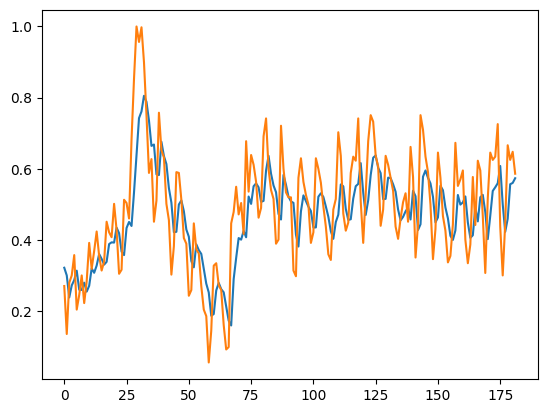

In [103]:
plt.plot(y_pred[200:])
plt.plot(y_train[200:])

In [104]:
y_pred_val = model.predict(X_val).flatten()
val_results = pd.DataFrame(data={"Val Predictions":y_pred_val, "Val Actual":y_val.flatten()})
val_results.head()

2/2 [==============================] - 0s 9ms/step


,Val Predictions,Val Actual
0,0.552398,0.565217
1,0.542070,0.350114
2,0.449647,0.343249
3,0.421976,0.565217
4,0.500801,0.546911


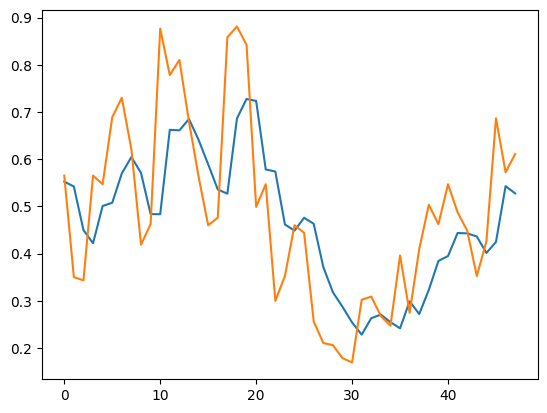

In [106]:
plt.plot(y_pred_val)
plt.plot(y_val)

In [107]:
y_pred_test = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={"Test Predictions":y_pred_test, "Test Actual":y_test.flatten()})
test_results.head()

2/2 [==============================] - 0s 10ms/step


,Test Predictions,Test Actual
0,0.547208,0.455378
1,0.489927,0.391304
2,0.451799,0.318078
3,0.408963,0.313501
4,0.389032,0.551487


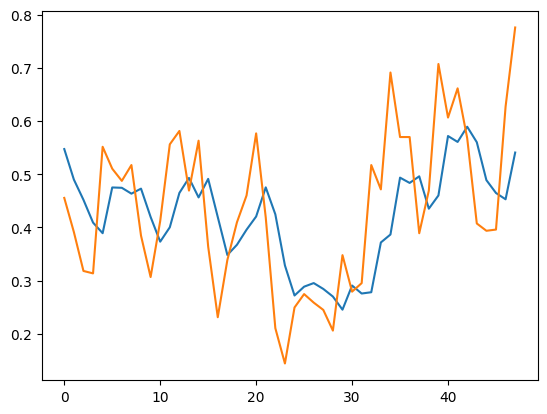

In [108]:
plt.plot(y_pred_test)
plt.plot(y_test)

In [109]:
def forecast_future(data, model, scaler, window_size, N, plot):
    """
    Predicts the next N values using a trained LSTM model.

    Parameters:
    - data: Original unscaled data (e.g., pd.Series or 1D np.array) of num_orders.
    - model: Trained LSTM model.
    - scaler: Fitted MinMaxScaler used during training.
    - window_size: Number of time steps used in each input sequence.
    - N: Number of future steps to forecast.

    Returns:
    - List of predicted values (in original scale).
    """

    # Ensure data is numpy array
    if isinstance(data, pd.Series):
        data = data.values
    elif isinstance(data, pd.DataFrame):
        data = data.iloc[:, 0].values  # Assume 1st column is num_orders

    # Scale the data
    scaled_data = scaler.transform(data.reshape(-1, 1)).flatten()

    # Start with the last window
    current_window = scaled_data[-window_size:].tolist()
    predictions_scaled = []

    for _ in range(N):
        input_seq = np.array(current_window[-window_size:]).reshape(1, window_size, 1)
        next_pred_scaled = model.predict(input_seq, verbose=0)[0][0]
        predictions_scaled.append(next_pred_scaled)
        current_window.append(next_pred_scaled)  # Append prediction to form next window

    # Inverse transform predictions to original scale
    predictions_scaled_array = np.array(predictions_scaled).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions_scaled_array).flatten()

    return predictions
    

future_preds = forecast_future(spd_df["num_orders"], model, scaler, WINDOW_SIZE, 80, True)



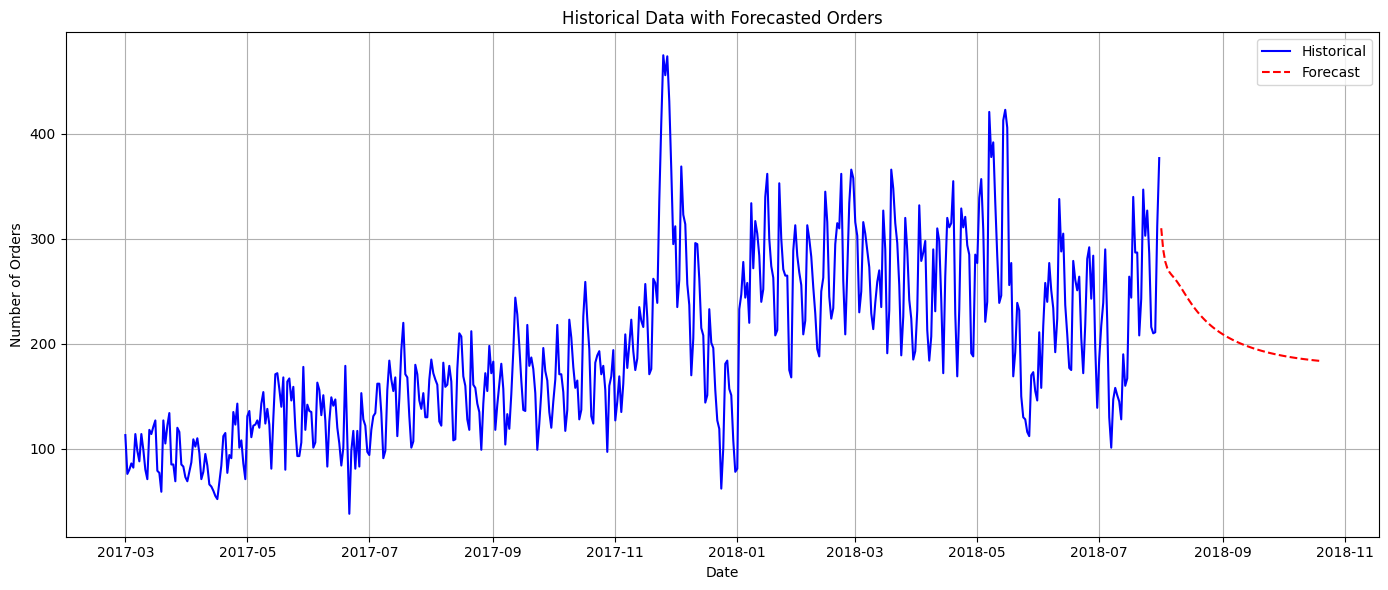

In [110]:

def plot_forecast(data, future_preds, date_column='order_purchase', value_column='num_orders'):
    """
    Plots the original time series along with forecasted future values.

    Parameters:
    - spd_df: Original DataFrame with date and order columns.
    - future_preds: List or array of forecasted values (in original scale).
    - date_column: Column name containing the dates.
    - value_column: Column name containing the values (e.g., 'num_orders').
    """

    # Convert dates
    data[date_column] = pd.to_datetime(data[date_column])
    historical_dates = data[date_column]
    historical_values = data[value_column]

    # Generate future dates
    last_date = historical_dates.iloc[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(future_preds))

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(historical_dates, historical_values, label='Historical', color='blue')
    plt.plot(future_dates, future_preds, label='Forecast', color='red', linestyle='dashed')
    plt.xlabel('Date')
    plt.ylabel('Number of Orders')
    plt.title('Historical Data with Forecasted Orders')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_forecast(spd_df, future_preds, date_column='order_purchase', value_column='num_orders')
